## **1) Imports and connection to Google services**

In [2]:
# -*- coding: utf-8 -*-
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import itertools
from collections import Counter
from wordcloud import WordCloud
import os, shutil
import csv

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Mounted at /content/drive


# **2) Parameters & data importing**

In [27]:
dir = '/content/drive/Othercomputers/My MacBook Pro/Documents/Research/Projects/LevothyroxSentimentAnalysis/Colab Notebooks finaux/data/' # Files directory (in/out)

# Data importing
df = pd.read_csv(dir + 'dataset_doctissimo_updated.csv', encoding='utf8')
print('\n*****************\nFile <dataset_doctissimo_updated.csv> has been loaded') 
df.head()


*****************
File <dataset_doctissimo_updated.csv> has been loaded


,date,user,text,url,year,words_count
0,2020-03-21,freesia53,suivre thyroidite hasimoto deconvenue levothyr...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,52
1,2020-03-13,petitbouch​on,medecin prescrit hypothyroidie secondaire tsh ...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,16
2,2020-03-13,Susanne in F,equivalent pifometre savoir exactement dosage ...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,24
3,2020-03-13,NotYourMaj​esty,hypothyroidie traitement an quotidiennement mi...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,34
4,2020-03-11,Clem120,date savoir fille atteinte syndrome interrupti...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,31


In [28]:
label = pd.read_csv(dir + 'sentiment_prediction_all_cleaning_steps.csv', encoding='utf8')
print('File <sentiment_prediction_all_cleaning_steps.csv> has been loaded\n*****************\n') 

File <sentiment_prediction_all_cleaning_steps.csv> has been loaded
*****************



In [22]:
ll = pd.read_csv(dir + 'sentiment_prediction_w_lemmatization.csv', encoding='utf8')
ll.head()

,Unnamed: 0,text,prediction
0,0,suivie thyroidite hasimoto deconvenues levothy...,__label__negative
1,1,medecin prescrit hypothyroidie secondaire tsh ...,__label__negative
2,2,equivalent pifometre sait exactement dosage re...,__label__negative
3,3,hypothyroidie traitement ans quotidiennement m...,__label__negative
4,4,date sait fille atteinte syndrome interruption...,__label__negative


In [10]:
ll

,Unnamed: 0,text,prediction
0,0,suivie thyroidite hasimoto deconvenues levothy...,__label__negative
1,1,medecin prescrit hypothyroidie secondaire tsh ...,__label__negative
2,2,equivalent pifometre sait exactement dosage re...,__label__negative
3,3,hypothyroidie traitement ans quotidiennement m...,__label__negative
4,4,date sait fille atteinte syndrome interruption...,__label__negative
...,...,...,...
6768,6768,endocrinologue prescrit prise sang verifie ver...,__label__negative
6769,6769,converser atteinte thyroidite hashimoto traite...,__label__negative
6770,6770,montrent hypothyroidie fier tsh medicament tsh,__label__positive
6771,6771,taux tsh hyperthyroidie faudrait revoir medeci...,__label__negative


In [7]:
label.head()

,Unnamed: 0,text,prediction
0,0,suivie thyroidite hasimoto deconvenuer levothy...,__label__negative
1,1,medecin prescrire hypothyroidi secondaire tsh ...,__label__positive
2,2,equivalent pifometre savoir exactement dosage ...,__label__positive
3,3,hypothyroidie traitemer ans quotidiennement mi...,__label__negative
4,4,date savoir fille atteinte syndrome interrupti...,__label__negative


In [11]:
label

,Unnamed: 0,text,prediction
0,0,suivie thyroidite hasimoto deconvenuer levothy...,__label__negative
1,1,medecin prescrire hypothyroidi secondaire tsh ...,__label__positive
2,2,equivalent pifometre savoir exactement dosage ...,__label__positive
3,3,hypothyroidie traitemer ans quotidiennement mi...,__label__negative
4,4,date savoir fille atteinte syndrome interrupti...,__label__negative
...,...,...,...
6768,6768,endocrinologue prescrire pris sang verifie ver...,__label__negative
6769,6769,converser atteinte thyroidite hashimoto traite...,__label__negative
6770,6770,montrent hypothyroidie fier tsh medicamer tsh,__label__positive
6771,6771,taux tsh hyperthyroidie falloir revoir medecin...,__label__negative


# **3) Define frequencies & Functions**

In [29]:
# Define frequencies
frequencies = {}
frequencies['Y'] = {'label': 'yearly', 'format': '%Y'}
frequencies['M'] = {'label': 'monthly', 'format': '%Y_%m'}
frequencies['W'] = {'label': 'weekly', 'format': '%Y_%U'}
frequencies['D'] = {'label': 'daily', 'format': '%Y_%m_%d'}

def word_occurence(df):
    words = df['text'].str.split()  
    full_list = list(itertools.chain(*words))
    counts = Counter(full_list)
    index = []
    values = []
    for key, item in counts.items():
        index.append(key)
        values.append(item)
    return pd.DataFrame(data={'occurence':values}, columns=['occurence'], index=index)
        
def n_gram(df, n_gram_size):
    # An n-gram is a contiguous sequence of n items from a given sample of text
    tokens = ' '.join([text for text in df['text']])
    tokens = tokens.split()
    ngrams = zip(*[tokens[i:] for i in range(n_gram_size)])
    list = [' '.join(ngram) for ngram in ngrams]
    counts = Counter(list)
    index = []
    values = []
    for key, item in counts.items():
        index.append(key)
        values.append(item)
    return pd.DataFrame(data={'occurence':values}, columns=['occurence'], index=index)
'''
def words_cloud(period, df, show=False):
    #fig = None
    wc = None
    all_text = ' '.join([text for text in df['text']])
    all_text = all_text.strip()
    try:    
        wc = WordCloud(width=800, height=500,random_state=21, max_font_size=110, collocations=False).generate(all_text)
    except ValueError:
        print('Value Error: ', period.strftime('%Y_%m_%d'), 'text: [', all_text,']')
        return None
    fig = plt.figure(figsize=(20, 12))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    if show:
        plt.show() 
    plt.close(fig) # Close the window displaying WC (too much memory used)   
    return fig    
'''    
def sentiment_number(row):
   if row['sentiment'] == '__label__positive':
      return 1
   if row['sentiment'] == '__label__negative':
      return 0

def save_csv(df):
    for key, frequency in frequencies.items():
        df_grouped = df.groupby(pd.Grouper(freq=key))
        index = 0
        f = open(dir + '/clustering/' + frequency['label'] + '.csv', 'w')
        for period, group in df_grouped:
            if len(group) > 0:
                df1 = word_occurence(group).nlargest(10, ['occurence'])
                lst_1 = []
                if not df1.empty:
                    lst_1 = [text for text in df1.index]
                if len(lst_1) < 10:
                    lst_1.extend(['']*(10-len(lst_1)))
                fragment_1 = ','.join(lst_1) 
                df2 = n_gram(group, 2).nlargest(10, ['occurence'])
                lst_2 = []
                if not df2.empty:
                    lst_2 = [text for text in df2.index]
                if len(lst_2) < 10:
                    lst_2.extend(['']*(10-len(lst_2)))
                fragment_2 = ','.join(lst_2)
                xs_p = 100*len(group[group['sentiment'] == '__label__positive'])/len(group)
                xs_n = 100*len(group[group['sentiment'] == '__label__negative'])/len(group)
                line = str(index) + ',' + period.strftime(frequencies[key]['format']) + ',' + fragment_1 + ',' + fragment_2 + ',' + str(xs_p) +',' + str(xs_n) + '\n'
                f.write(line)
            index+=1
        f.close() 

'''
# Save WC in folders : yearly - monthly - weekly - daily and sort by normal_0 or abnormal_1 tag // 30 min of execution time
def save_word_clouds(df, start, end):
    # Define intervals
    intervals = []
    # Normal 
    intervals.append({'index':0, 'name':'normal', 'mask':(df.index < start) | (df.index > end)})
    # Abnormal
    intervals.append({'index':1, 'name':'abnormal', 'mask':(df.index >= start) & (df.index <= end)})
    for item in intervals:  
        for key, frequency in frequencies.items():
            df_grouped = df[item['mask']].groupby(pd.Grouper(freq=key))
            for period, group in df_grouped:
                if len(group.index) > 0:
                    file_path = '/content/drive/MyDrive/Thèse Lévothyrox/cnn/'+ frequency['label'] + '/' + item['name'] + '/'  + 'world_cloud_' + frequency['label'] + '_' + period.strftime(frequency['format']) + '.png'
                    #print(period, file_path)
                    fig = words_cloud(period, group)
                    if not fig is None:
                        fig.savefig(file_path)
'''
  
def clean_folders():
    folders = []
    folders.append(dir + 'clustering')
    #folders.append('/content/drive/MyDrive/Thèse Lévothyrox/cnn/yearly/normal')
    #folders.append('/content/drive/MyDrive/Thèse Lévothyrox/cnn/monthly/normal')
    #folders.append('/content/drive/MyDrive/Thèse Lévothyrox/cnn/weekly/normal')
    #folders.append('/content/drive/MyDrive/Thèse Lévothyrox/cnn/daily/normal')
    #folders.append('/content/drive/MyDrive/Thèse Lévothyrox/cnn/yearly/abnormal')
    #folders.append('/content/drive/MyDrive/Thèse Lévothyrox/cnn/monthly/abnormal')
    #folders.append('/content/drive/MyDrive/Thèse Lévothyrox/cnn/weekly/abnormal')
    #folders.append('/content/drive/MyDrive/Thèse Lévothyrox/cnn/daily/abnormal')
    for folder in folders:
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
              print('Failed to delete %s. Reason: %s' % (file_path, e))

# **4) Clean folders (clustering & CNN)**

**Warning ! It destroy all the content of clustering & CNN folders**

In [18]:
# Execution starts here   
clean_folders()
print('All files in clustering & CNN folders are deleted\n******************************')

All files in clustering & CNN folders are deleted
******************************


# **5) DF formating & CSV export for clustering**

In [30]:
print('DF label file (sentiment_prediction_all-cleaning_steps.csv)\n******************************', label)
print('\nDF without labeling\n******************************', df)

df['sentiment'] = label['prediction'] # Add a column
df['date'] = pd.to_datetime(df['date']) # Cast date to datetime
df['text'] = df['text'].astype(str) # Cast text column to string
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '') # Clean text
df = df.set_index('date') # Set date column as index
print('\nDF with labeling\n******************************')
print(df)

# Add a numeric column reflecting sentiment value
df['sentiment_number'] = df.apply (lambda row: sentiment_number(row), axis=1)
print('\nDF with labeling and sentiment number\n******************************')
print(df)

# Save labeled dataframe to csv
#df.to_csv(dir + 'dataset_doctissimo_updated_w_lemmatization.csv', index=False, sep=',', header=True, encoding='utf8')
#print('\n******************************\nFile <dataset_doctissimo_updated_w_lemmatization.csv> has been exported')

# Generate and save top_10 words, top_10 bi-grams, +/- sentiments in csv files
save_csv(df)
print('CSV files are saved in /content/drive/MyDrive/Thèse Lévothyrox/clustering/ : yearly.csv, monthly.csv, weekly.csv, daily.csv\n******************************')

DF label file (sentiment_prediction_all-cleaning_steps.csv)
******************************       Unnamed: 0                                               text  \
0              0  suivie thyroidite hasimoto deconvenuer levothy...   
1              1  medecin prescrire hypothyroidi secondaire tsh ...   
2              2  equivalent pifometre savoir exactement dosage ...   
3              3  hypothyroidie traitemer ans quotidiennement mi...   
4              4  date savoir fille atteinte syndrome interrupti...   
...          ...                                                ...   
6768        6768  endocrinologue prescrire pris sang verifie ver...   
6769        6769  converser atteinte thyroidite hashimoto traite...   
6770        6770      montrent hypothyroidie fier tsh medicamer tsh   
6771        6771  taux tsh hyperthyroidie falloir revoir medecin...   
6772        6772  pareille commencer tsh levothyrox tsh baisse l...   

             prediction  
0     __label__negative  
1   

<ipython-input-30-82153d9f98b4>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '') # Clean text


CSV files are saved in /content/drive/MyDrive/Thèse Lévothyrox/clustering/ : yearly.csv, monthly.csv, weekly.csv, daily.csv
******************************


In [33]:
daily = pd.read_csv(dir + '/clustering/daily.csv', encoding='utf8')
daily

,0,2016_01_01,tsh,endo,baisse,levothyrox,montrent,hypothyroidie,fier,medicament,...,hypothyroidie fier,fier tsh,tsh medicament,medicament tsh,tsh taux,taux tsh,tsh hyperthyroidie,hyperthyroidie falloir,66.66666666666667,33.333333333333336
0,1,2016_01_02,prise,thyroide,normal,levothyrox,mcg,commencer,doser,falloir,...,levothyrox mcg,mcg commencer,commencer mcg,mcg brutal,brutal espere,espere symptomes,symptomes surdosage,surdosage commencer,16.666667,83.333333
1,2,2016_01_03,endocrinologue,medecin,contact,decouvert,hyperthyroidie,jasmin,traitant,traitement,...,medecin decouvert,decouvert hyperthyroidie,hyperthyroidie jasmin,jasmin medecin,medecin traitant,traitant endocrinologue,endocrinologue traitement,traitement voulai,33.333333,66.666667
2,3,2016_01_04,dosage,neomercazole,fatiguer,jour,endocrinologue,hypo,extreme,thyroide,...,thyroide modifie,modifie dosage,dosage falloir,falloir minimum,minimum semaine,semaine constater,constater reel,reel effet,25.000000,75.000000
3,5,2016_01_06,vie,maladie,norme,an,thyroide,labo,crise,millimètre,...,chiffre thyroide,prise sang,maladie hashimoto,labo norme,difficile equilibre,equilibre asymptomatique,asymptomatique premiere,premiere phase,30.000000,70.000000
4,6,2016_01_07,levothyrox,prise,tsh,sang,resultat,apprecie,lob,traitement,...,lob gauche,face anterieur,anterieur pol,accus grade,examen tsh,prendre traitement,scintigraphie permettra,permettra activite,50.000000,50.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,1527,2020_03_07,dernier,resultat,fevrier,montrent,surdosage,comprend,medecin,vouloir,...,fevrier montrent,montrent surdosage,surdosage comprend,comprend medecin,medecin vouloir,vouloir baisser,baisser doser,doser traitement,0.000000,100.000000
1090,1529,2020_03_09,thyroxine,levothyrox,falloir,endo,vouloir,baisse,jallais,hypo,...,baisse jallais,jallais hypo,hypo arret,arret cytomel,cytomel cur,cur naime,naime augment,augment thyroxin,0.000000,100.000000
1091,1531,2020_03_11,savoir,syndrome,date,fille,atteinte,interruption,tige,petuitair,...,fille atteinte,atteinte syndrome,syndrome interruption,interruption tige,tige petuitair,petuitair traitement,traitement croissance,croissance thyroide,0.000000,100.000000
1092,1533,2020_03_13,maroc,medecin,semaine,hypothyroidie,probleme,stock,commence,renseigner,...,hypothyroidie secondaire,secondaire tsh,tsh probleme,probleme falloir,falloir constituer,constituer stock,stock correspondre,correspondre prise,66.666667,33.333333


In [32]:
monthly = pd.read_csv(dir + '/clustering/monthly.csv', encoding='utf8')
monthly

,0,2016_01,tsh,levothyrox,traitement,semaine,medecin,hormone,doser,falloir,...,anti tpo,norme labo,falloir semaine,thyroidienne libre,antirecepteur tsh,doser hormone,falloir doser,doser levothyrox,38.853503184713375,61.146496815286625
0,1,2016_02,levothyrox,tsh,medecin,traitement,euthyral,falloir,norme,thyroide,...,levothyrox euthyral,pris sang,taux tsh,euthyral levothyrox,ui millilitre,augment levothyrox,comprim euthyral,doser hormone,39.597315,60.402685
1,2,2016_03,tsh,medecin,thyroide,levothyrox,traitement,sang,resultat,an,...,doser levothyrox,prise poids,resultat pris,probleme thyroide,norme labo,hormone thyroidienne,bas norme,resultat tsh,39.726027,60.273973
2,3,2016_04,tsh,levothyrox,medecin,norme,sang,resultat,falloir,anti,...,anti tpo,norme labo,doser levothyrox,refair prise,anti thyroperoxydase,tsh norm,norme lt,pris sang,41.269841,58.730159
3,4,2016_05,tsh,endocrinologue,medecin,norme,sang,traitement,hypothyroidie,resultat,...,anti tpo,auto immun,hormone thyroidienne,prise poids,norme lt,mal gorge,clairement hypothyroidie,medecin traiter,49.350649,50.649351
4,5,2016_06,tsh,levothyrox,traitement,resultat,medecin,thyroide,falloir,norme,...,ac anti,anti thyroglobuline,anti thyroperoxydase,anti tpo,bas norme,doser levothyrox,thyroidite partum,pris sang,44.067797,55.932203
5,6,2016_07,levothyrox,tsh,semaine,doser,medecin,traitement,falloir,resultat,...,anti tpo,ul millilitre,doser levothyrox,prise sang,levothyrox falloir,norme labo,labo taux,pdt pdt,48.611111,51.388889
6,7,2016_08,tsh,medecin,levothyrox,norme,anti,resultat,bas,hashimoto,...,medecin traiter,norme labo,tsh bas,bas norme,millilitre norme,interval reference,auto immun,augment levothyrox,45.714286,54.285714
7,8,2016_09,levothyrox,thyroide,tsh,medecin,endocrinologue,an,symptomes,hypothyroidie,...,arret traitement,prise sang,prescrit levothyrox,ul millilitre,hormone thyroidienne,levothyrox tsh,ui millilitre,millilitre libre,38.461538,61.538462
8,9,2016_10,tsh,norme,levothyrox,traitement,medecin,thyroide,maladie,endocrinologue,...,uul millilitre,pmol norm,norm ng,ng norme,prise poids,pris sang,norme tsh,tsh uul,35.000000,65.000000
9,10,2016_11,levothyrox,tsh,medecin,normal,falloir,grossesse,hypo,an,...,taux tsh,grossesse falloir,levothyrox symptomes,gros probleme,levothyrox an,levothyrox tsh,ramener tsh,tsh autour,47.115385,52.884615


# 6) Sentiment Evolution Plots

In [ ]:
dir = '/content/drive/MyDrive/Thèse Lévothyrox/2 JP Colab Notebooks/data/' # Files directory (in/out)

# Data importing
df = pd.read_csv(dir + 'dataset_doctissimo_updated_all_cleaning_steps_labeled.csv', encoding='utf8')
print('\n*****************\nFile <dataset_doctissimo_updated_all_cleaning_steps_labeled.csv> has been loaded') 



*****************
File <dataset_doctissimo_updated_all_cleaning_steps_labeled.csv> has been loaded


In [ ]:
df_ = pd.read_csv(dir + 'dataset_doctissimo_updated.csv', encoding='utf8')


In [ ]:
df_


,date,user,text,url,year,words_count
0,2020-03-21,freesia53,suivre thyroidite hasimoto deconvenue levothyr...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,52
1,2020-03-13,petitbouch​on,medecin prescrit hypothyroidie secondaire tsh ...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,16
2,2020-03-13,Susanne in F,equivalent pifometre savoir exactement dosage ...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,24
3,2020-03-13,NotYourMaj​esty,hypothyroidie traitement an quotidiennement mi...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,34
4,2020-03-11,Clem120,date savoir fille atteinte syndrome interrupti...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,31
...,...,...,...,...,...,...
6768,2016-01-02,Smoothie27​7,endocrinologue prescrit prise sang verifie ver...,https://forum.doctissimo.fr/sante/thyroide-pro...,2016,42
6769,2016-01-02,seb58dy,converser atteinte thyroidit hashimoto traitem...,https://forum.doctissimo.fr/sante/thyroide-pro...,2016,12
6770,2016-01-01,glo18fz,montrent hypothyroidie fier tsh medicament tsh,https://forum.doctissimo.fr/sante/thyroide-pro...,2016,6
6771,2016-01-01,.Dr40av,taux tsh hyperthyroidie falloir revoir medecin...,https://forum.doctissimo.fr/sante/thyroide-pro...,2016,10


In [ ]:
label = pd.read_csv(dir + 'sentiment_prediction_all_cleaning_steps.csv', encoding='utf8')
print('File <sentiment_prediction_all_cleaning_steps.csv> has been loaded\n*****************\n') 

File <sentiment_prediction_all_cleaning_steps.csv> has been loaded
*****************



In [ ]:
label

,Unnamed: 0,text,prediction
0,0,suivie thyroidite hasimoto deconvenuer levothy...,__label__negative
1,1,medecin prescrire hypothyroidi secondaire tsh ...,__label__positive
2,2,equivalent pifometre savoir exactement dosage ...,__label__positive
3,3,hypothyroidie traitemer ans quotidiennement mi...,__label__negative
4,4,date savoir fille atteinte syndrome interrupti...,__label__negative
...,...,...,...
6768,6768,endocrinologue prescrire pris sang verifie ver...,__label__negative
6769,6769,converser atteinte thyroidite hashimoto traite...,__label__negative
6770,6770,montrent hypothyroidie fier tsh medicamer tsh,__label__positive
6771,6771,taux tsh hyperthyroidie falloir revoir medecin...,__label__negative


In [ ]:
df['date'] = pd.to_datetime(df_['date'])
 

df = df.set_index(df['date'])


In [ ]:
df

,user,text,url,year,words_count,sentiment,sentiment_number,date
date,,,,,,,,
2020-03-21,freesia53,suivie thyroidite hasimoto deconvenuer levothy...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,52,__label__negative,0,2020-03-21
2020-03-13,petitbouch​on,medecin prescrire hypothyroidi secondaire tsh ...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,16,__label__positive,1,2020-03-13
2020-03-13,Susanne in F,equivalent pifometre savoir exactement dosage ...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,24,__label__positive,1,2020-03-13
2020-03-13,NotYourMaj​esty,hypothyroidie traitemer ans quotidiennement mi...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,34,__label__negative,0,2020-03-13
2020-03-11,Clem120,date savoir fille atteinte syndrome interrupti...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,31,__label__negative,0,2020-03-11
...,...,...,...,...,...,...,...,...
2016-01-02,Smoothie27​7,endocrinologue prescrire pris sang verifie ver...,https://forum.doctissimo.fr/sante/thyroide-pro...,2016,42,__label__negative,0,2016-01-02
2016-01-02,seb58dy,converser atteinte thyroidite hashimoto traite...,https://forum.doctissimo.fr/sante/thyroide-pro...,2016,12,__label__negative,0,2016-01-02
2016-01-01,glo18fz,montrent hypothyroidie fier tsh medicamer tsh,https://forum.doctissimo.fr/sante/thyroide-pro...,2016,6,__label__positive,1,2016-01-01


In [ ]:
df_neg_M_2017 = pd.DataFrame()
df_pos_M_2017 = pd.DataFrame()

  
df_neg_M_2017['Count'] = df[(df.index.year == 2017)& (df['sentiment'] == '__label__negative')].resample('M', on='date').size()
df_neg_M_2017['Date'] = df_neg_M_2017.index
df_neg_M_2017['Sentiment'] = 'Negative'

df_pos_M_2017['Count'] = df[(df.index.year == 2017)& (df['sentiment'] == '__label__positive')].resample('M', on='date').size()
df_pos_M_2017['Date'] = df_pos_M_2017.index
df_pos_M_2017['Sentiment'] = 'Positive'

df_sent_M_2017 = df_neg_M_2017.append(df_pos_M_2017)
df_sent_M_2017

,Count,Date,Sentiment
date,,,
2017-01-31,56,2017-01-31,Negative
2017-02-28,39,2017-02-28,Negative
2017-03-31,83,2017-03-31,Negative
2017-04-30,36,2017-04-30,Negative
2017-05-31,53,2017-05-31,Negative
2017-06-30,41,2017-06-30,Negative
2017-07-31,57,2017-07-31,Negative
2017-08-31,157,2017-08-31,Negative
2017-09-30,622,2017-09-30,Negative


In [ ]:
df_neg_Y = pd.DataFrame()
df_pos_Y = pd.DataFrame()

  
df_neg_Y['Count'] = df[ (df['sentiment'] == '__label__negative')].resample('Y', on='date').size()
df_neg_Y['Date'] = df_neg_Y.index
df_neg_Y['Sentiment'] = 'Negative'

df_pos_Y['Count'] = df[(df['sentiment'] == '__label__positive')].resample('Y', on='date').size()
df_pos_Y['Date'] = df_pos_Y.index
df_pos_Y['Sentiment'] = 'Positive'

df_sent_Y = df_neg_Y.append(df_pos_Y)
df_sent_Y

,Count,Date,Sentiment
date,,,
2016-12-31,752,2016-12-31,Negative
2017-12-31,1992,2017-12-31,Negative
2018-12-31,888,2018-12-31,Negative
2019-12-31,342,2019-12-31,Negative
2020-12-31,81,2020-12-31,Negative
2016-12-31,571,2016-12-31,Positive
2017-12-31,1202,2017-12-31,Positive
2018-12-31,655,2018-12-31,Positive
2019-12-31,238,2019-12-31,Positive


In [ ]:
df_neg_M = pd.DataFrame()
df_pos_M = pd.DataFrame()

  
df_neg_M['Count'] = df[ (df['sentiment'] == '__label__negative')].resample('M', on='date').size()
df_neg_M['Date'] = df_neg_M.index
df_neg_M['Sentiment'] = 'Negative'

df_pos_M['Count'] = df[(df['sentiment'] == '__label__positive')].resample('M', on='date').size()
df_pos_M['Date'] = df_pos_M.index
df_pos_M['Sentiment'] = 'Positive'

df_sent_M = df_neg_M.append(df_pos_M)
df_sent_M

,Count,Date,Sentiment
date,,,
2016-01-31,96,2016-01-31,Negative
2016-02-29,90,2016-02-29,Negative
2016-03-31,88,2016-03-31,Negative
2016-04-30,111,2016-04-30,Negative
2016-05-31,78,2016-05-31,Negative
...,...,...,...
2019-11-30,11,2019-11-30,Positive
2019-12-31,3,2019-12-31,Positive
2020-01-31,18,2020-01-31,Positive


## Charts & plots**

Distribution of messages by sentiment (0: negative / 1: positive):
-> all dates
******************************


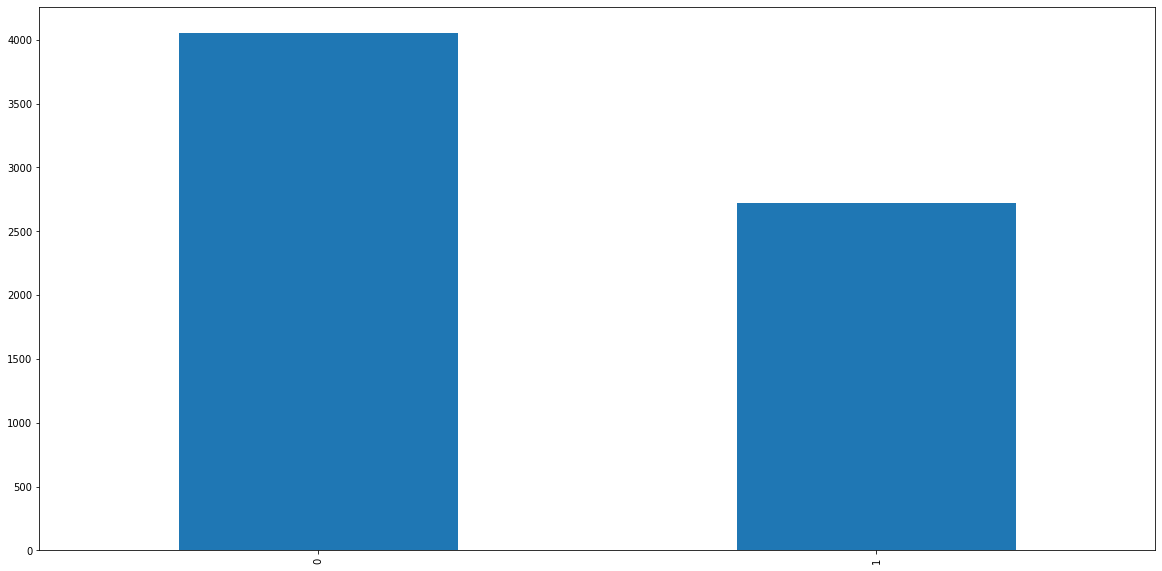

In [ ]:
# Distribution of messages by sentiment
# All dates
fig, ax = plt.subplots(figsize=(20, 10))
df['sentiment_number'].value_counts().plot(ax=ax, kind='bar')
print('Distribution of messages by sentiment (0: negative / 1: positive):\n-> all dates\n******************************')
plt.show()



Distribution of messages by sentiment (0: negative / 1: positive):
-> 2017
******************************


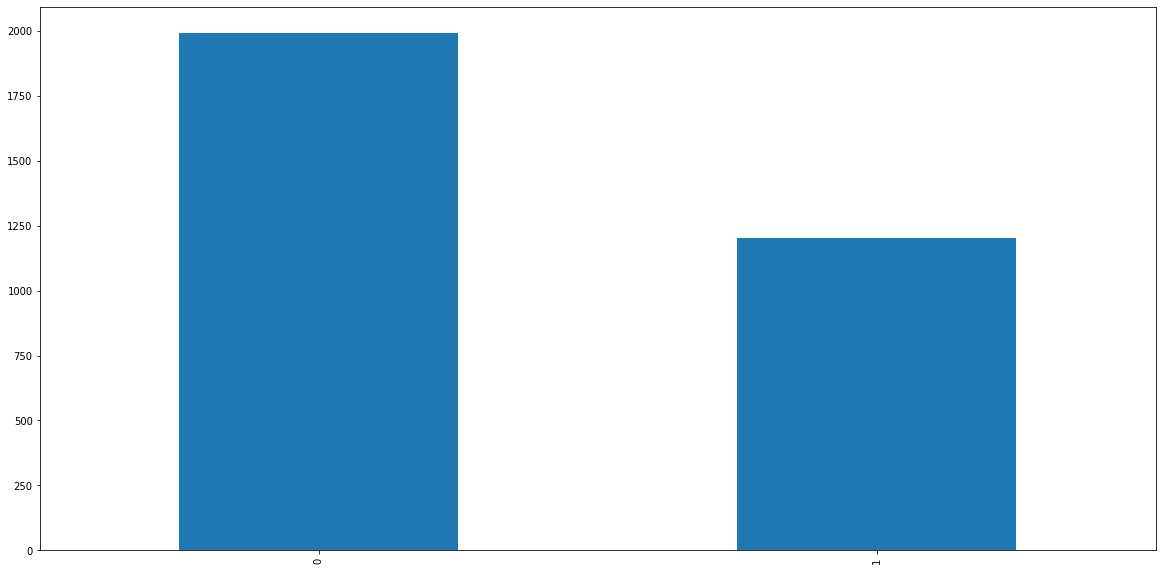

In [ ]:
# Selected year
fig, ax = plt.subplots(figsize=(20, 10))
df[df.index.year == 2017]['sentiment_number'].value_counts().plot(ax=ax, kind='bar')
print('\nDistribution of messages by sentiment (0: negative / 1: positive):\n-> 2017\n******************************')
plt.show()



Distribution of messages by sentiment (0: negative / 1: positive):
-> 2016-02
******************************


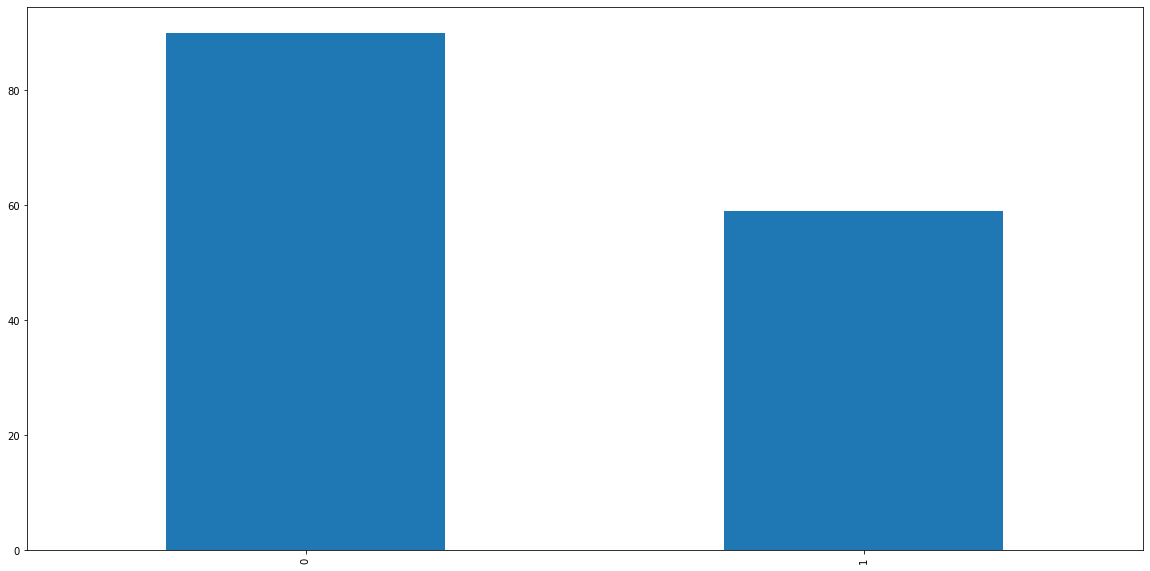

In [ ]:
# Selected month
fig, ax = plt.subplots(figsize=(20, 10))
df[(df.index.year == 2016) & (df.index.month == 2)]['sentiment_number'].value_counts().plot(ax=ax, kind='bar')
print('\nDistribution of messages by sentiment (0: negative / 1: positive):\n-> 2016-02\n******************************')
plt.show()



Distribution of messages by sentiment (0: negative / 1: positive):
-> 2016-03-18
******************************


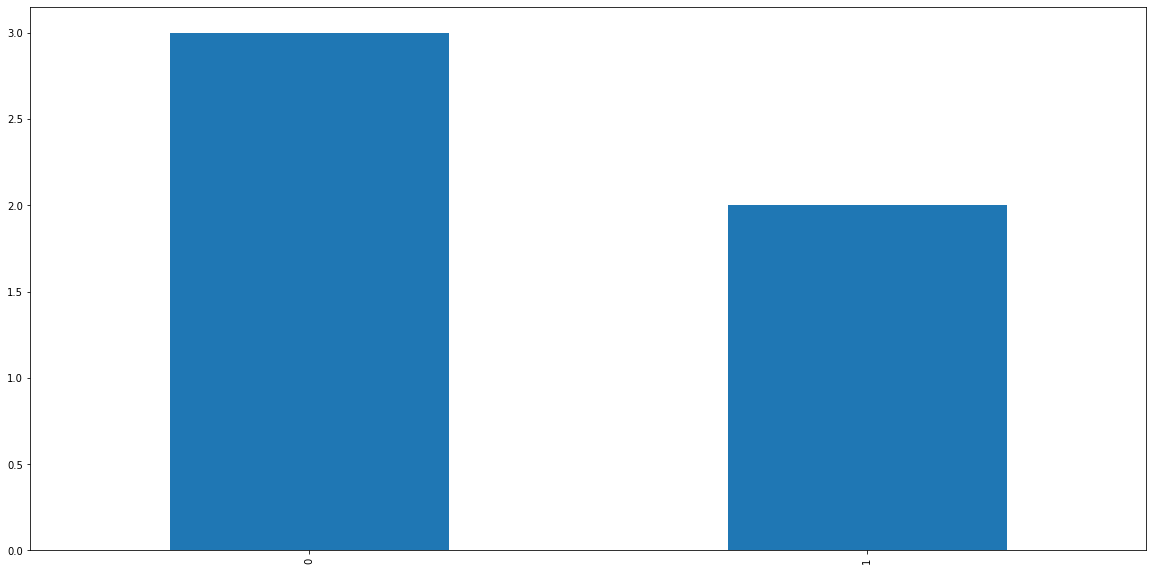

In [ ]:
# Selected day
fig, ax = plt.subplots(figsize=(20, 10))
df[df.index == '2016-03-18']['sentiment_number'].value_counts().plot(ax=ax, kind='bar')
print('\nDistribution of messages by sentiment (0: negative / 1: positive):\n-> 2016-03-18\n******************************')
plt.show()




Distribution of messages by sentiment (0: negative / 1: positive):
-> 2016-03-18 to 2016-03-25
******************************


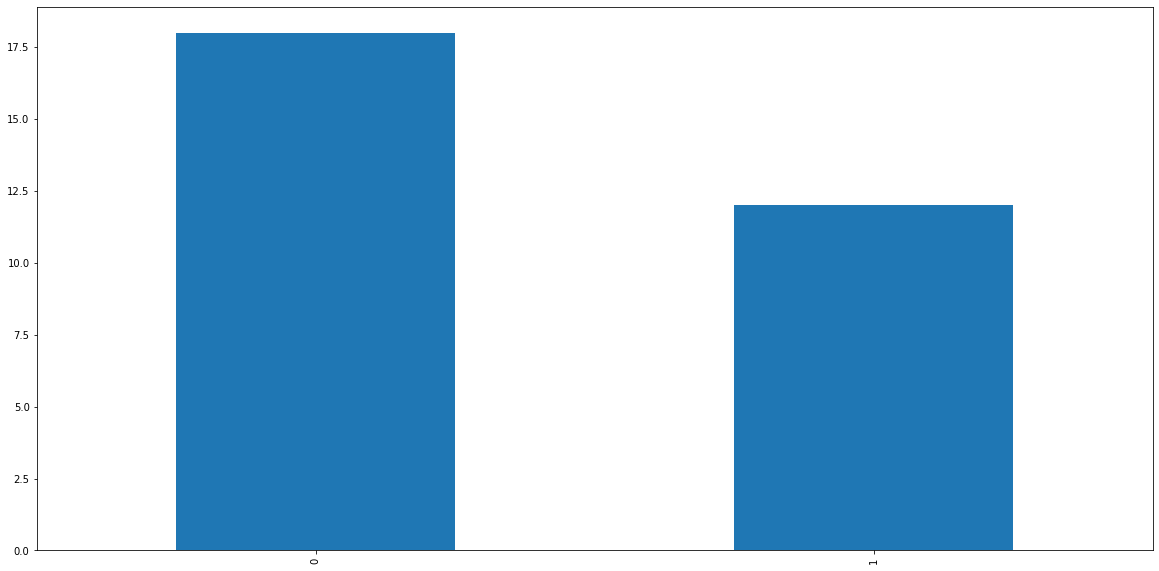

In [ ]:
# Selected range
fig, ax = plt.subplots(figsize=(20, 10))
df[(df.index >= '2016-03-18') & (df.index < '2016-03-25')]['sentiment_number'].value_counts().plot(ax=ax, kind='bar')
print('\nDistribution of messages by sentiment (0: negative / 1: positive):\n-> 2016-03-18 to 2016-03-25\n******************************')
plt.show()




Historical line chart per selected sentiment (__label__negative) in 2017
******************************


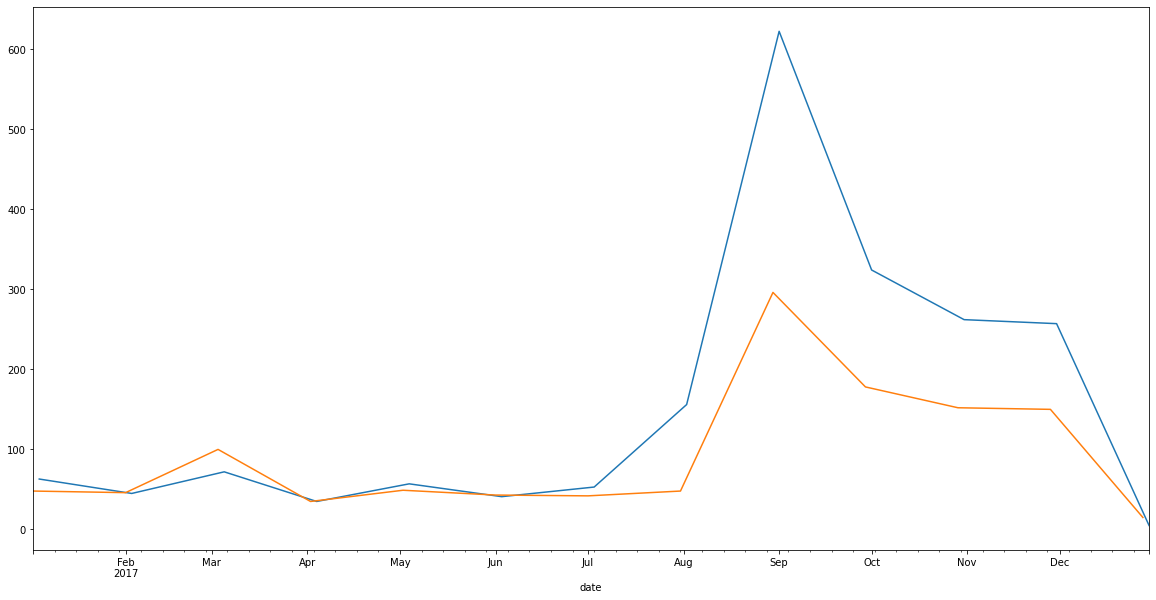

In [ ]:
# Historical line chart per selected sentiment
freq = pd.offsets.Day(30)
fig, ax = plt.subplots(figsize=(20, 10))
ax = df[(df.index.year == 2017) & (df['sentiment'] == '__label__negative')].resample(freq).size().plot.line(ax=ax)
ax = df[(df.index.year == 2017) & (df['sentiment'] == '__label__positive')].resample(freq).size().plot.line(ax=ax)

print('\nHistorical line chart per selected sentiment (__label__negative) in 2017\n******************************')
plt.show()



In [ ]:
import altair as alt
from vega_datasets import data
import pandas as pd


source = df_sent_M_2017.reset_index()

alt.Chart(source).mark_line(point = True).encode(
    x = alt.X("Date:O", timeUnit="yearmonth", title="Date"),
    y="rank:O",
    color=alt.Color("Sentiment:N")
).transform_window(
    rank="rank()",
    sort=[alt.SortField("Count", order="descending")],
    groupby=["Date"]
).properties(
    title="Sentiment Evolution",
    width=600,
    height=150,
)



alt.Chart(...)

In [ ]:
chart_M_2017 = alt.Chart(source).mark_line(point = True).encode(
    x = alt.X("Date:O", timeUnit="yearmonth", title="Date"),
    y="Count:Q",
    color=alt.Color("Sentiment:N")
).properties(
    title="Sentiment Evolution 2017",
    width=600,
    height=150,
)


In [ ]:
source = df_sent_Y.reset_index()

chart_Y_All = alt.Chart(source).mark_line(point = True).encode(
    x = alt.X("Date:O", timeUnit="year", title="Date"),
    y="Count:Q",
    color=alt.Color("Sentiment:N")
).properties(
    title="Sentiment Evolution (2016-2020)",
    width=600,
    height=150,
)

In [ ]:
source = df_sent_M.reset_index()

chart_M_All = alt.Chart(source).mark_line(point = True).encode(
    x = alt.X("Date:O", timeUnit="yearmonth", title="Date"),
    y="Count:Q",
    color=alt.Color("Sentiment:N")
).properties(
    title="Sentiment Evolution Per Month (2016-2020)",
    width=600,
    height=150,
)

In [ ]:
alt.vconcat(chart_Y_All,chart_M_All,chart_M_2017)


alt.VConcatChart(...)

In [ ]:
df.head()

,user,text,url,year,words_count,sentiment,sentiment_number,date
date,,,,,,,,
2020-03-21,freesia53,suivie thyroidite hasimoto deconvenuer levothy...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,52,__label__negative,0,2020-03-21
2020-03-13,petitbouch​on,medecin prescrire hypothyroidi secondaire tsh ...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,16,__label__positive,1,2020-03-13
2020-03-13,Susanne in F,equivalent pifometre savoir exactement dosage ...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,24,__label__positive,1,2020-03-13
2020-03-13,NotYourMaj​esty,hypothyroidie traitemer ans quotidiennement mi...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,34,__label__negative,0,2020-03-13
2020-03-11,Clem120,date savoir fille atteinte syndrome interrupti...,https://forum.doctissimo.fr/sante/thyroide-pro...,2020,31,__label__negative,0,2020-03-11


In [ ]:
source = df.reset_index()

alt.Chart(source).mark_line(point = True).encode(
    x = alt.X("date:O", timeUnit="year", title="Date"),
    y="Count:Q",
    color=alt.Color("Sentiment:N")
).properties(
    title="Sentiment Evolution (2016-2020)",
    width=600,
    height=150,
)

In [ ]:
# Historical line chart of comments per user
fig, ax = plt.subplots(figsize=(20, 10))
df[(df.index.year == 2016) & (df.index.month == 2)]['user'].value_counts().plot(ax=ax, kind='bar')
print('\nComments per user in 2016-02\n******************************')
plt.show()

# **7) WC saving for CNN algorithm**

**Warning ! 19 min of execution time**

In [ ]:
start = '2017-07-01' # Start of date range qualified as abnormal
end = '2017-12-31' # End of date range qualified as abnormal

print('Start of date range qualified as abnormal : ' + start + '\nEnd of date range qualified as abnormal : ' + end + '\n*****************************\n')
print('Generating .png files...')

# Generate and save wordclouds as .png image files 
save_word_clouds(df, start, end)
print('\n*****************************\n.png files have been saved in /content/drive/MyDrive/Thèse Lévothyrox/cnn/\n*****************************\n')

Start of date range qualified as abnormal : 2017-07-01
End of date range qualified as abnormal : 2017-12-31
*****************************

Generating .png files...

*****************************
.png files have been saved in /content/drive/MyDrive/Thèse Lévothyrox/cnn/
*****************************

